In [1]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install scikit-learn

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

You should consider upgrading via the 'c:\users\obabo\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# Задача классификации

Задача классификации - это задача присвоения класса данным. Так, например, имея метеорологические данные, мы можем предсказывать один из двух классов: будет дождь или нет, по тексту письма определить, спам это или нет. Также можно по картинке с животным присваивать ей один из классов “на картинке кошка”, “на картинке собака” или “на картинке бобер”. Другим примером может быть по видеозаписи фильма проставить метки жанров: триллер, хоррор, мелодрама и др.

Особенностью классической задачи классификации является наличие фиксированного числа предсказываемых классов. То есть, решая задачу, мы либо присваиваем данным один из классов, либо присваиваем несколько классов, но главное - **выборка классов фиксирована**.

Для пример сгенерируем случайные данные и постараемся разобраться, как решать задачу классификации данных:

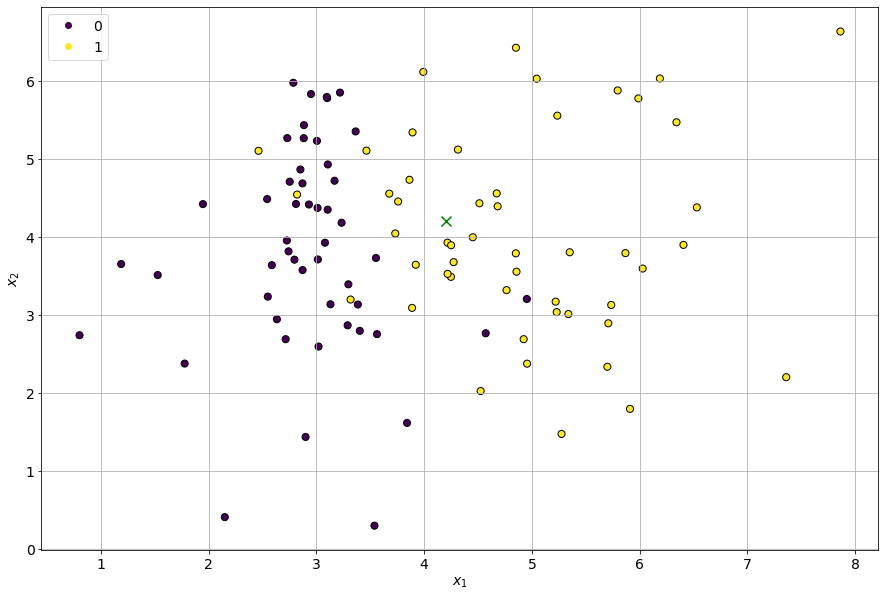

In [2]:
from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=100,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=2,
    random_state=RANDOM_STATE,
    shift=[4, 4]
)

X_new = np.array([[4.2, 4.2]])

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k')
plt.scatter(X_new[:, 0], X_new[:, 1], marker='x', s=100, edgecolor='k', c='green')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])

На изображении мы видим данные, каждая запись - это кружочек. Цвет кружочка определяет, какому классу относится запись в данных. Всего мы видим два класса: желтые (класс 1) и фиолетовые (класс 0) кружочки, а также две оси: $x_1$ и $x_2$. На деле $x_1$ и $x_2$ - это признаки в данных, а цвет кружочка - разметка класса в данных. 

Для примера положим, что признак $x_1$ - это рейтинг отеля на сайте, а признак $x_2$ - это скидка на проживание от отеля. В качестве классов для примера возьмем:
- Класс 1 (желтые) - стоит брать отель;
- Класс 0 (фиолетовые) - не стоит брать отель.

Зеленым крестиком выделена **новая** запись, для которой требуется определить класс, то есть решить, стоит брать отель с такими признаками или нет.

> Такая задача, в которой выбор всего из двух классов, называется **бинарной классификацией**: да/нет, правда/ложь, бутерброд/пицца, собачка/хомячок. Классы не обязательно должны быть противоположны.

Резюмируя, есть данные с разметкой по классам (в нашем случае "берем отель" или "не берем отель"), а значит мы имеем всего два класса для предсказания. Модель, соответственно, получая признаки на вход, должна предсказать, к какому классу отнести такую запись. 

Уже сейчас заметно, что задача классификации сильно отличается от задачи регрессии: 
- В задаче регрессии результатом предсказания модели является вещественное число, которое отражает характер данных, на которых модель обучалась. 
- В задаче классификации предсказанием модели является значение из фиксированного набора уникальных значений (для нашего случая, 0 или 1).

То есть, если в задаче регрессии мы стараемся повторить характер изменения зависимой переменной $y$ в зависимости от значений признаков $X$ (повторить характер движение точек на графике), то в задаче классификации мы стараемся найти такое разделение по признакам $X$, чтобы правильно присвоить класс данным (провести линию, которая разделит группы на графике).

> Если еще раз взглянуть на данные, то можно заметить, что затруднительно явно разделить группы классов (желтые и фиолетовые кружки), но не забывайте, что в данных бывает шум и промахи.

Также взглянем на данные `X_data` и разметку `y_data`, которые мы имеем:

In [3]:
X_data.shape, y_data.shape

((100, 2), (100,))

In [4]:
X_data[:3]

array([[3.23394531, 4.18332468],
       [3.07961675, 3.9276832 ],
       [3.01341491, 3.71308   ]])

In [5]:
y_data[:3]

array([0, 0, 0])

In [6]:
# Проверим уникальные значения
np.unique(y_data)

array([0, 1])

Как и ранее, данные представлены в виде 2D матрицы, в которой строки - записи, стобцы - признаки. Разметка (истинные данные) - одномерный вектор с проставленными классами (всего два класса - проверили уникальные значения).

# Логистическая регрессия

Логистическая регрессия - модель, применяемая для решения задачи классификации. 

Название подхода складывается из двух частей:

1. Регрессия - участвует в названии, так как на самом деле в основе модели лежит часть, которая идентична модели линейной регрессии 

$$
z=XW
$$ 

где $X$ - вектор признаков (или матрица данных) с единицей в качестве первого элемента, $W$ - вектор весов со смещение в качестве первого элемента. Обратите внимание, что результатом умножения весов на значения признаков не является конечное предсказание модели - за это отвечает вторая часть.

2. Логистическая - конечное предсказание модели делается на основе логистической функции $$h_W(X)=\sigma(z)=\frac{1}{1+e^{-z}}$$ где $z$ - результат вычисления линейной составляющей.

> Другое название логистической функции - **сигмоида**.

Таким образом, модель логистической регрессии имеет следующую функцию предсказания:
$$
h_W(X) = \sigma(XW)
$$

Для отображения функции сигмоиды реализуем недостающую функцию `sigmoid()`:

In [7]:
# TODO
def sigmoid(z):
    sgm = 1/(1+np.exp(-z))
    return sgm

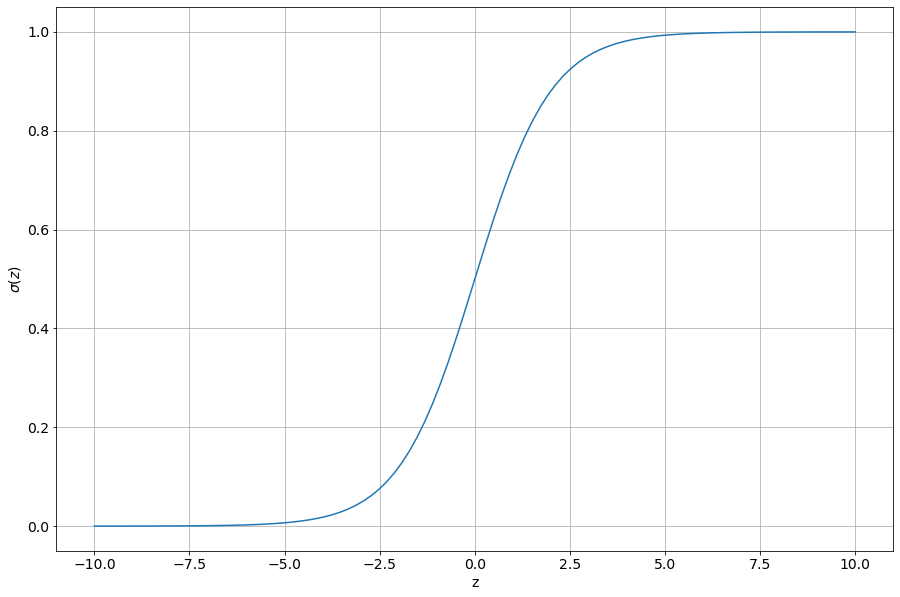

In [8]:
X = np.linspace(-10, 10, 100)
Y = sigmoid(X)

plt.plot(X, Y)
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.grid()

Как видно из графика сигмоиды, выходное значение лежит в диапазоне $[0; 1]$. 

Сигмоида здесь показывает очень полезную для понимания вещь - уверенность присвоения тому или иному классу! То есть, если мы предсказываем, брать отель или нет, то нам нужно определить, какой из классов будет соответствовать уверенности равной единице. В нашем примере логичнее всего для высокой уверенности поставить класс “берем отель”, а для низкой - “не берем отель”.

Таким образом предсказание модели логистической регрессии - это не просто конкретный класс, а степень уверенности, по которой можно определить, к какому классу из двух (в бинарной классификации) отнести входные данные.

# Функция предсказания

Начало реализации модели происходит с реализации функции предсказания. Для начала вновь вспомним и реализуем функцию предсказания линейной регрессии:

In [9]:
# TODO - функция предсказания линейной части
def predict_linreg(X, W):
    ones = np.ones((X.shape[0], 1), dtype=int)
    X = np.concatenate((ones, X), axis=1)
    z = np.dot(X, W)
    return z

In [10]:
# Проверим на паре тестов
W = np.array([1, 2, 3])
X = np.array([
    [3, 4],
    [2, 3],
    [0, 1]
])
y_true = np.array([19, 14, 4])
y_pred = predict_linreg(X, W)

assert np.all(y_true == y_pred)

После этого, напишем реализацию функции предсказания степени уверенности:

In [11]:
# TODO - функция предсказания степени уверенности
# NOTE - proba ~ probability
def predict_proba(X, W):
    z = predict_linreg(X, W)
    y = sigmoid(z)
    return y

> Функция названа `predict_proba()`, а не `predict()`, потому что по факту, это еще не конечное предсказание модели. Задача модели присвоить класс, а реализация данной функции возвращает степень уверенности, что будет использовано дальше.

In [12]:
# Проверим на паре тестов
W = np.array([1, 2, 3])
X = np.array([
    [-3, 4],
    [2, -3],
    [0, -1]
])
y_true = np.array([0.999088, 0.01798, 0.1192])
y_pred = predict_proba(X, W)

# Проверка сделана через близость значений из-за округлений
assert np.all(np.abs(y_true-y_pred) < 1e-5)

Для того, чтобы присвоить одному или другому классу мы выбирает определенный порог по значению уверенности, по которому будет определяться принадлежность классу. Допустим, в качестве порога выберем значение 0.5 - все значения уверенности выше данного порога считаются присвоенными классу 1, иначе - классу 0.

Конечная функция `predict()` на вход принимает не только данные и веса, но и величину порога. 

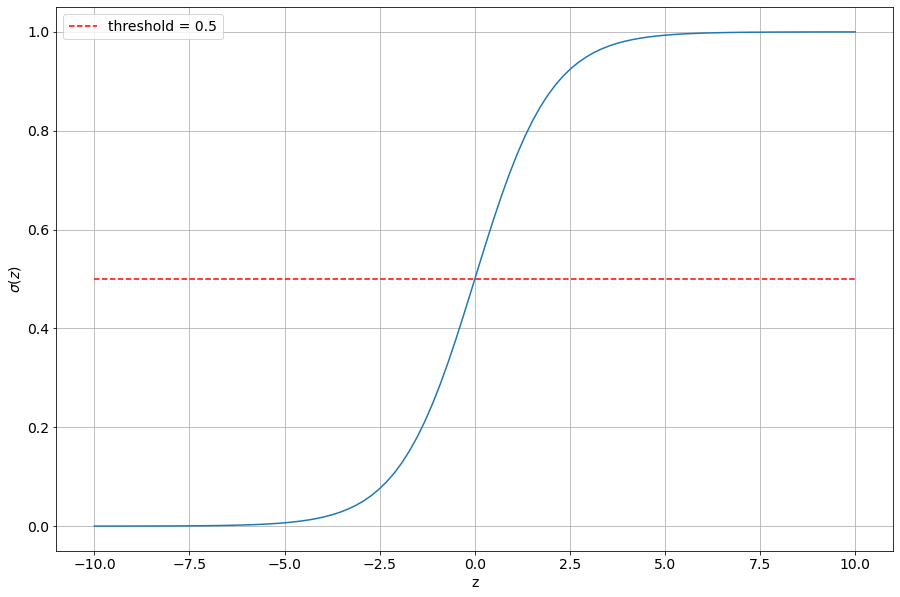

In [13]:
# Для примера отобразим порог вместе с функцией сигмоиды

X = np.linspace(-10, 10, 100)
Y = sigmoid(X)
Y_thrsh = np.full_like(X, 0.5)

plt.plot(X, Y)
plt.plot(X, Y_thrsh, 'r--', label='threshold = 0.5')
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.legend()
plt.grid()

In [14]:
# TODO - функция конечного предсказания
#         результат должен содержать присвоенный класс
def predict(X, W, threshold):
    y_cls = predict_proba(X, W)
    bit = y_cls > threshold
    y_cls[bit] = 1
    y_cls[~bit] = 0
    return y_cls

In [15]:
# Проверим на паре тестов
W = np.array([1, 2, 3])
X = np.array([
    [-3, 4],
    [2, -3],
    [0, -1]
])
y_true = np.array([1, 0, 0])
y_pred = predict(X, W, 0.5)

assert np.all(y_true == y_pred)

Отлично! Теперь мы имеет функцию предсказания, которая позволяет классифицировать данные на основе весов и установленного порога.

# Визуализация предсказаний

Для случая классификации с двумя признаками полезно для понимания провести визуализацию границы решения (decision boundary) модели:

In [16]:
def plot_2d_decision_boundary(X, W, y_true):
    x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
    x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
    xx, yy = np.meshgrid(x1_vals, x2_vals)

    y_pred = predict_proba(np.c_[xx.ravel(), yy.ravel()], W)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred)
    pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=30, edgecolor='k')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True)
    plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])
    plt.show()

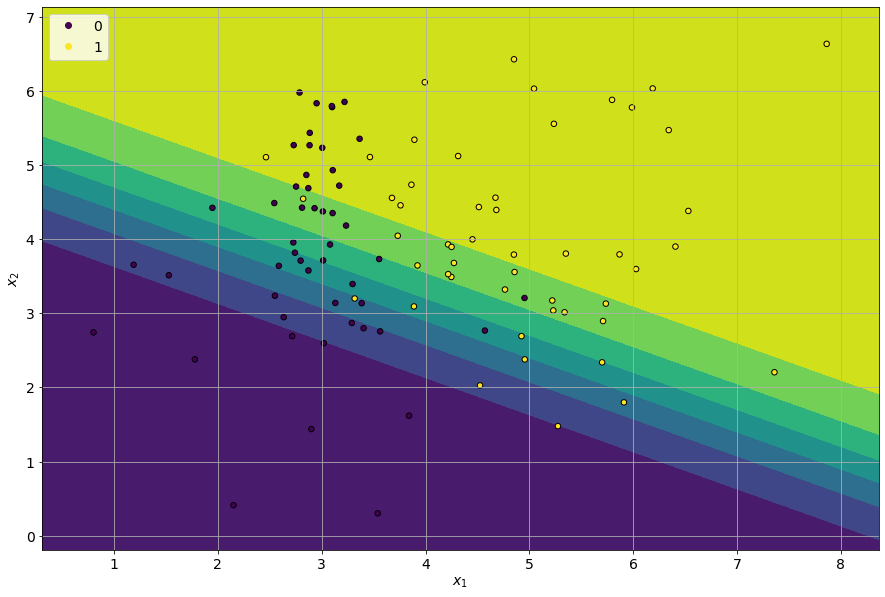

In [17]:
# Выберем случайные веса и установим переменные
rand_W = [-10, 1, 2]
X = X_data
y_true = y_data

plot_2d_decision_boundary(X_data, rand_W, y_data)

По рисунку сразу можно увидеть, как распределяются степени уверенности и в каких областях модель предсказывает определенные классы.

Как и в случае с регрессией, задача классификации также требует численных показателей для сравнения и оценки пользы тех или иных подходов в ходе экспериментирования.

## Задание

Замените функцию `predict_proba()` на `predict()` (создав новую функцию отображения), отобразите данные и постарайтесь описать, почему изменился результат отображения:

In [18]:
# TODO
def plot_2d_decision_boundary_predict(X, W, y_true):
    x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
    x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
    xx, yy = np.meshgrid(x1_vals, x2_vals)

    y_pred = predict(np.c_[xx.ravel(), yy.ravel()], W, 0.5)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred)
    pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=30, edgecolor='k')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True)
    plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])
    plt.show()

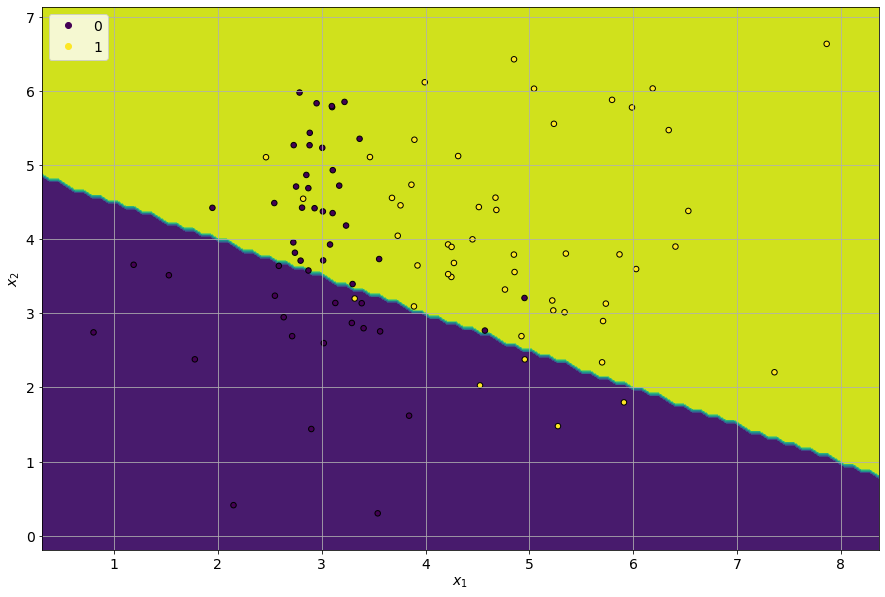

In [19]:
rand_W = [-10, 1, 2]
X = X_data
y_true = y_data

plot_2d_decision_boundary_predict(X_data, rand_W, y_data)

# Вывод
В случае с predict_proba мы использовали для оценки непрерывную функцию. Поэтому четкой границы решения не получислось вывести. В случае с predict используется уже дискретные значения оценки [0,1]. Граница решений представляет собой линию и четко разделяет классификации.    

# Метрики

## Основные показатели

Базовые метрики классификации рассчитываются на основе основных показателей:
- True Positive - Верно положительные, предсказанный положительный класс (класс 1) соответвует истинному значению;
- True Negative - Верно негативные, предсказанный негативный класс (класс 0) соответвует истинному значению;
- False Positive - Ложно положительный, модель присвоила положительный класс, хотя размечен как отрицательный.
- False Negative - Ложно отрицательный, модель присвоила отицательный класс, хотя размечен как положительный.

> В бинарной классификации положительным считается тот класс, который мы предсказываем и которому соответсвует уверенность предсказания = 1, отрицательным классом считается другой класс, которому соответсвует уверенность = 0. В случае классификации спама, если уверенности равной 1 соответсвует присвоение класса "спам", то этот класс считается положительным, а "не спам" - отрицательный. Если наоборот, задача предсказывать письма "не спам", то этот класс считается положительным, а класс "спам" отрицательным и он соответсвует уверенности равной нулю.

Для понимания немного развернем определение показателей. Мы предсказываем “брать отель” или “не брать отель” и у нас с этими классами есть вектор предсказаний и вектор истинных значений. Также мы помним, что для работы мы выбрали класс “берем отель” как положительный (соответствует высокой уверенности). Показатели описывают следующую ситуацию:
- TP - действительно положительный, то есть когда предсказание равно “берем отель” и истинное значение - “берем отель” (предсказание == аннотация == положительный класс);
- TN - действительно отрицательный, то есть когда предсказание равно “не берем отель” и истинное значение - “не берем отель” (предсказание == аннотация == отрицательный класс);
- FP - неправильно предсказали положительный, то есть когда предсказание равно “берем отель”, а истинное значение - “не берем отель” (предсказание != аннотация, предсказание == положительный класс);
- FN - неправильно предсказали отрицательный, то есть когда предсказание равно “не берем отель”, а истинное значение - “берем отель” (предсказание != аннотация, предсказание == отрицательный класс);

А теперь финт ушами, что если мы для оценки возьмем класс "не берем отель" как положительный, а "берем отель" как отрицательный (просто для понимания). Тогда у нас происходит следующая трансформация:
- TP и TN меняются местами;
- FP и FN меняются местами.

> Можете это сами проверить по определениям - замените названия классов.

Расчет данных показателей заключается в сравнении вектора присвоенных классов и вектора размеченных классов.

In [20]:
# TODO - реализуйте функцию получения показателей
def get_truefalse_metrics(y_true, y_pred):
    TP=np.sum((y_true==1)&(y_pred==1))
    TN=np.sum((y_true==0)&(y_pred==0))
    FP=np.sum((y_true==0)&(y_pred==1))
    FN=np.sum((y_true==1)&(y_pred==0))
    return TP, TN, FP, FN

In [21]:
# Небольшой тест
y_true = np.array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1])
y_pred = np.array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

TP, TN, FP, FN = get_truefalse_metrics(y_true, y_pred)
assert np.all([TP == 3, TN == 4, FP == 2, FN == 5])

## Матрица ошибок

Одним из способов визуализации данных показателей является представление под названием Confusion Matrix (матрица замешательств/матрица ошибок). Структура матрицы выглядит следующим образом:

> Помним, что 1 - берем отель, 0 - не берем отель. Класс "берем отель" считается для нас положительным.

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan=2>Предсказание</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=3>Истинное</td>
            <td></td>
            <td>0</td>
            <td>1</td>
        </tr>
        <tr>
            <td>0</td>
            <td>TN</td>
            <td>FP</td>
        </tr>
        <tr>
            <td>1</td>
            <td>FN</td>
            <td>TP</td>
        </tr>
    </tbody>
</table>

Для визуализации матрицы полезно построить 2D массив и разместить в нем элементы:

In [22]:
# TODO - постройте матрицу ошибок в виде 2D квадратного массива
def get_confusion_matrix(y_true, y_pred):
    TP, TN, FP, FN = get_truefalse_metrics(y_true, y_pred)
    conf_matrix = np.array([[TN, FP], [FN, TP]])
    return conf_matrix

In [23]:
# Небольшой тест
y_true = np.array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1])
y_pred = np.array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

conf_matrix = get_confusion_matrix(y_true, y_pred)
assert np.all(conf_matrix == np.array([[4, 2], [5, 3]]))

Для отображения удобно воспользоваться пакетом `seaborn`:

In [24]:
def show_confusion_matrix(conf_matrix):
    ax = sns.heatmap(conf_matrix, annot=True)
    plt.xlabel('Предсказанное')
    plt.ylabel('Истинное')
    plt.show()

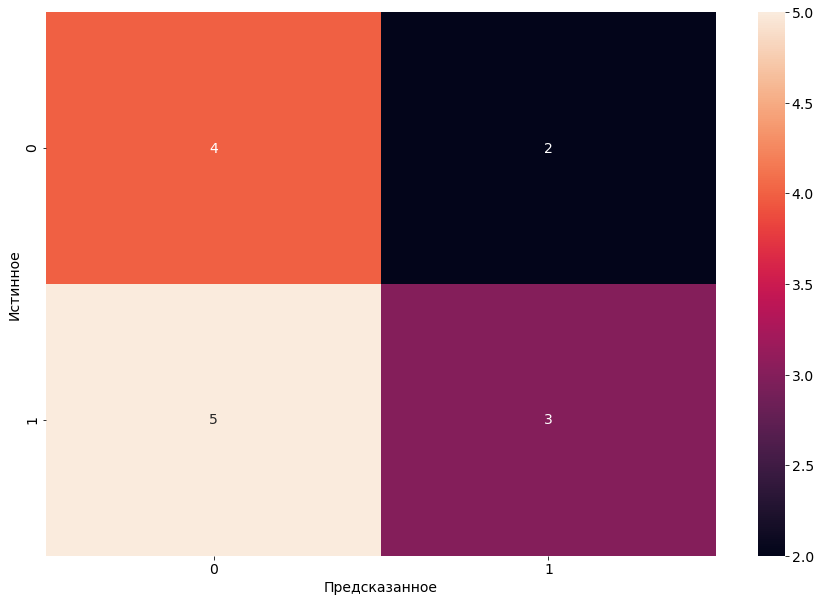

In [25]:
show_confusion_matrix(conf_matrix)

## Задание


Произведите предсказание классов на данных `X_data` и отобразите результаты предсказания в виде матрицы ошибок.

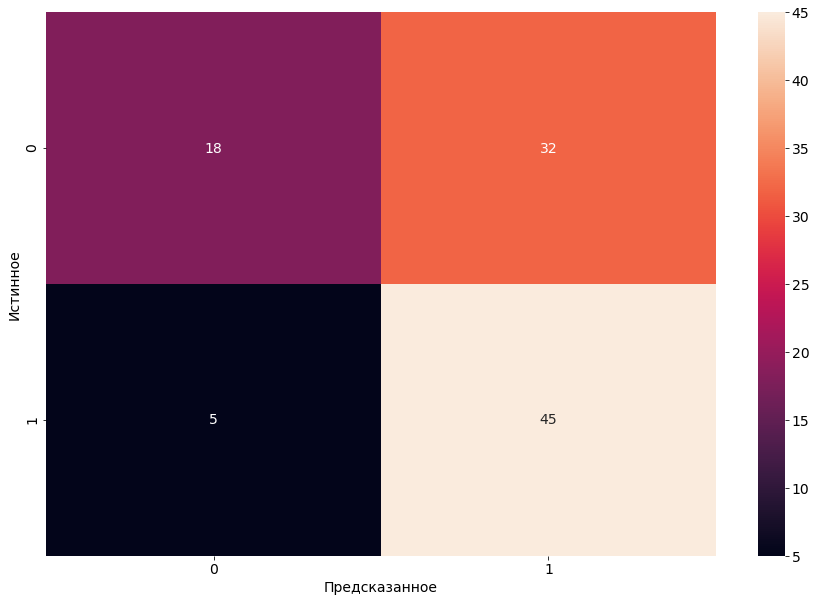

In [26]:
# TODO - используйте rand_W для предсказания
y_true = y_data
y_pred = predict(X_data, rand_W, 0.5)
conf_matrix = get_confusion_matrix(y_true, y_pred)
show_confusion_matrix(conf_matrix)

## Достоверность, точность, полнота, F-мера (Accuracy, Precision, Recall, F1)

Для начала введем обозначения для данных формул, чтобы обсудить, что они обозначают:
- Accuracy
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$

Достоверность - метрика, которая оценивает, насколько "верно" работает модель по всем классам. Данная оценка строит отношение всех верно оцененных классов ко всему количеству примеров. Показатель будет равен единице, если не имеется **ни одной ошибки**. Удобна для общей оценки классификатора, но для глубокого анализа не подходит.

- Precision
$$
Presicion = \frac{TP}{TP+FP}
$$

Точность - метрика оценки конкретного класса, чувствительна к промахам присвоения оцениваемого класса другим записям. Если мы хотим получить оценку точности для класса 1, то берем значение $TP$ для этого класса (на диагонали) и делим на сумму всех элементов в этой колонке (что является $FP$ для класса 1 вместе с $TP$). Показатель стремится к единице, если оцениваемый класс не присвоен другим записям.

> Еще зовется *specificity* (специфичность)

- Recall
$$
Recall = \frac{TP}{TP+FN}
$$

Полнота - метрика оценки конкретного класса. Полнота оценивает то, как много значений класса 1 были действительно предсказаны как класс 1. Если мы хотим получить оценку точности для класса 1, то берем значение $TP$ для этого класса (на диагонали) и делим на сумму всех элементов в этой строке (что является $FN$ для класса 1 вместе с $TP$). Показатель стремится к единице, если в предсказаниях оцениваемый класс не имеет промахов.

> Еще зовется *sensitivity* (чувствительность)

- F1
$$
F1 = 2*\frac{Precision*Recall}{Precision+Recall}
$$

F-мера - гармоническое среднее двух показателей. По сути стремится к единице, если оба показателя (точность и полнота) стремятся к единице. Используется как обобщение работы классификатора на данном классе.

> Все рассмотренные метрики имеют диапазон $[0; 1]$.

Пока что отдохнем и напишем их реализации:

In [27]:
def calculate_accuracy(y_true, y_pred):
    # TODO - функция вычисления точности
    TP, TN, FP, FN = get_truefalse_metrics(y_true, y_pred)
    acc = (TP+TN)/(TP+TN+FP+FN)
    return acc

def calculate_recall_precision_f1(y_true, y_pred, class_index):
    '''
    class_index - Индекс класса для которого делается оценка показателей
    '''
    # TODO - функция вычисления показателей recall, precision
    TP, TN, FP, FN = get_truefalse_metrics(y_true, y_pred)
    if class_index == 1:
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
    if class_index == 0:
        precision = TN/(TN+FN)
        recall = TN/(TN+FP)
    f1 = (2*precision*recall)/(precision+recall)
    return recall, precision, f1

In [28]:
# Небольшой тест
y_true = np.array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1])
y_pred = np.array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

acc = calculate_accuracy(y_true, y_pred)
recall_1, precision_1, f1_1 = calculate_recall_precision_f1(y_true, y_pred, 1)
recall_0, precision_0, f1_0 = calculate_recall_precision_f1(y_true, y_pred, 0)

print(f'Class 1 metrics: {recall_1, precision_1, f1_1}')
print(f'Class 0 metrics: {recall_0, precision_0, f1_0}')
print(f'Accuracy: {acc}')

assert np.all([acc == 0.5, recall_1 == 0.375, precision_1 == 0.6])

Class 1 metrics: (0.375, 0.6, 0.4615384615384615)
Class 0 metrics: (0.6666666666666666, 0.4444444444444444, 0.5333333333333333)
Accuracy: 0.5


## Зачем столько метрик?

Разберем понятия точности и полноты более подробно. На первый взгляд может показаться, что отличий от достоверности крупных нет, но эти две метрики несут очень важный смысл.

Допустим, мы делаем классификатор, который оценивает возможность получения кредита (класс 1 - "можно" дать кредит, класс 0 - "нельзя"). Для банка очень важно, чтобы предсказания были как можно точнее, **НО**, так как ошибок не избежать, то вводятся следующие требования к ошибкам: 
- если будут предсказания, когда истинное значение - "можно", а предсказал "нельзя", то это не так страшно;
- предсказания с истинным "нельзя", а предсказанным "можно" - очень плохо.

Когда требование определено, давайте оценим такой случай:

In [29]:
def show_classification_metrics(y_true, y_pred):
    acc = calculate_accuracy(y_true, y_pred)
    recall_1, precision_1, f1_1 = calculate_recall_precision_f1(y_true, y_pred, 1)
    recall_0, precision_0, f1_0 = calculate_recall_precision_f1(y_true, y_pred, 0)

    print(f'Class 1 metrics: {recall_1, precision_1, f1_1}')
    print(f'Class 0 metrics: {recall_0, precision_0, f1_0}')
    print(f'Accuracy: {acc}')

In [30]:
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])
y_pred = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

show_classification_metrics(y_true, y_pred)

Class 1 metrics: (1.0, 0.7, 0.8235294117647058)
Class 0 metrics: (0.5714285714285714, 1.0, 0.7272727272727273)
Accuracy: 0.7857142857142857


В данном примере мы видим, что часть клиентов была предсказана как "можно" (класс 1) при истинном значении "нельзя". Как помним из требования - такое поведение нежелательно для банка - нужно понять, как увидеть это в метриках.

Проанализируем поведение класса 1 ("можно") по метрикам `recall_1, precision_1`.

Мы видим, что все записи, которые имеют класс 1 в истинных значениях были предсказаны верно - это означает, что классификатор работает максимально "полно", он не присваивает другой класс в тех записях, в которых истинно стоит оцениваемый класс 1. Это нам и показывает метрика полноты. По формуле, данные предсказания не имеют $FN$ примеров для класса 1. Точность в свою очередь не максимальна, так как есть записи, где класс 1 присвоен записям с другим истинным классом, а это и есть $FP$ для класса 1.

Можем ли мы здесь выявить метрику, которая отражает поведение, желаемое банком? Похоже, что да - это точность для класса 1. Если у нас появляются записи, когда класс 1 ("можно") присвоен классу с истинным классом 0 ("нельзя"), то это $FP$ и точность падает.

Для проверки проверим второй пример:

In [31]:
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])
y_pred = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

show_classification_metrics(y_true, y_pred)

Class 1 metrics: (0.42857142857142855, 1.0, 0.6)
Class 0 metrics: (1.0, 0.6363636363636364, 0.7777777777777778)
Accuracy: 0.7142857142857143


Теперь в наших предсказания есть случаи, когда присвоен класс 0 при том, что истинный класс 1 - такие ошибки менее критичны, но при этом надо не забывать, что это все еще ошибки. Как ранее и предполагали, так как нет случаев, когда было присвоено "можно" с истинным значением "нельзя", то показатель точности для класса 1 имеет максимальное значение. 

При этом обратите внимание, что показатель `accuracy` практически не изменился, по факту он лишь показывает, что имеются промахи, но не позволяет проанализировать характер промахов.

Таким образом, в данном примере модель работает лучше по отношению к требованиям в сравнении с первым примером, хотя показатели точности стали чуть хуже. В ходе разработки модели данные показатели позволяют более детально осознавать поведение модели и по возможности подстраивать под желаемое поведение в соответсвии с задачей.

# Разделение данных на обучение/тест со стратификацией

Так как уже подготовлены функции оценки показателей, то разделим данные на обучение/тест для дальнейшей оценки. Важным момент при решении задачи классификации является применение **стратификации** по истинным классам.

Идея **стратификации** заключается в том, что результирующие сплиты должны иметь такое же соотношение записей с истинными классам, как в исходных данных.

Так, например, если мы имеем 200 записей, 120 относятся к классу 0, а остальные к классу 1 - то есть исходное соотношение классов:
- класс 0 - 60% от выборки;
- класс 1 - 40% от выборки.

Сплит со стратификацией явно сохраняет соотношение в результирующих выборках:

При выделении 50% на тест (100 записей данных на тест) группы должны получиться следующие:
- обучающая выборка (50%): 60 записей класса 0 и 40 - класса 1
- тестовая выборка (50%): 60 записей класса 0 и 40 - класса 1

При выделении 20% на тест (40 записей на тест) группы дожны получиться следующие:
- обучающая выборка (80%): 96 записей класса 0 и 64 - класса 1
- тестовая выборка (20%): 24 записей класса 0 и 16 - класса 1

Таким образом, необходимо написать функцию разделения на выборки, которая явно сохранит соотношение классов в выборках.

In [32]:
# TODO - функция сплита со стратификацией
def train_test_split_stratified(X, y, test_size):
    # Объединим X и y, чтобы работать с одним массивом
    Xy = np.concatenate((X, y.reshape((X.shape[0], 1))), axis=1)
    # Создадим листы Xy_train и Xy_test, в которые будем формировать выборки
    Xy_train = []
    Xy_test = []
    # Создаем цикл по уникальным значениям (классам) массива y
    #   (так как стратифицируем по целевым классам)
    for class_unique in np.unique(Xy[:, 2]):
        # Получаем индексы записей, у которых значение равно уникальному
        #   значению в итерации (равно выбранному классу в итерации)
        # numpy.where()
        index_unique = np.where(Xy[:, 2] == class_unique)[0]

        # Перемешиваем индексы, чтобы выборка была случайной
        # numpy.random.permutation()
        index_unique = np.random.permutation(index_unique)

        # Умножаем test_size на количество записей класса,
        #   чтобы получить количество записе этого класса, которое 
        #   уходит на тест
        # Не забудьте, что количество должно быть int
        sum_test = int(test_size * index_unique.shape[0])

        # Выбираем индексы записей, которые пойдут на тест [:cls_n_test]
        # Остальные индексы пойдут на обучение
        index_test = index_unique[:sum_test]
        index_learn = index_unique[sum_test:]


        # Расширяем массив Xy_train данными по индексам для обучения
        # Расширяем массив Xy_test данными по индексам для теста
        # list.extend()
        Xy_test.extend(Xy[index_test])
        Xy_train.extend(Xy[index_learn])

    # Перемешаем еще раз полученные Xy_train и Xy_test
    # numpy.random.permutation()
    Xy_test = np.random.permutation(Xy_test)
    Xy_train = np.random.permutation(Xy_train)
    # Разделим обратно на X_train, X_test, y_train, y_test
    # X - все колонки до последней, y - последняя колонка
    X_train = Xy_train[:, :-1]
    y_train = Xy_train[:, -1]
    X_test = Xy_test[:, :-1]
    y_test = Xy_test[:, -1]
    return X_train, X_test, y_train, y_test

In [33]:
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split_stratified(X_data, y_data, TEST_SIZE)

assert np.all([X_train.shape[0] == 70, X_test.shape[1] == X_data.shape[1], y_test.shape[0] == 30])

In [34]:
X_test.shape

(30, 2)

После разделения можно провести оценку показателей на тестовой выборке для дальнейшего сравнения:

In [35]:
# TODO - выполните предсказание с порогом 0.5 и отобразите метрики
y_true = y_test
y_pred = predict(X_test, rand_W, 0.5)
show_classification_metrics(y_true, y_pred)

Class 1 metrics: (0.8666666666666667, 0.52, 0.65)
Class 0 metrics: (0.2, 0.6, 0.3)
Accuracy: 0.5333333333333333


# Функция потерь



Модель логистической регрессии обучается с использование градиентного спуска, поэтому требуется в первую очередь определить функцию потерь для данной задачи.

> Тут можно сказать, что почему бы не производить минимизацию, как в линейной регрессии, то есть по функции *Mean-Squared Error*, но не все так просто. Экспериментально показано, что такой подход формирует невыпуклую (non-convex) плоскость ошибки, по которой градиентный спуск (или другой метод оптимизации) пытается найти оптимум. Поэтому, для задач классификации используют свою функцию потерь.

Задача функции потерь - заставить уверенность предсказания сойтись от нуля к единице (в случае, если истинное значение - один) и наоборот. 

Для схождения к единице используется функция потерь от ошибки: $$J_1=-log(y_{pred})$$ 
Для схождения к нулю используется аналогичная функция, но с инвертированным аргументом: $$J_2=-log(1-y_{pred})$$

Графики функций представлены ниже.


<ipython-input-36-b3f46c3d66e0>:2: RuntimeWarning: divide by zero encountered in log
  J_1 = -np.log(Y)
<ipython-input-36-b3f46c3d66e0>:3: RuntimeWarning: divide by zero encountered in log
  J_2 = -np.log(1-Y)


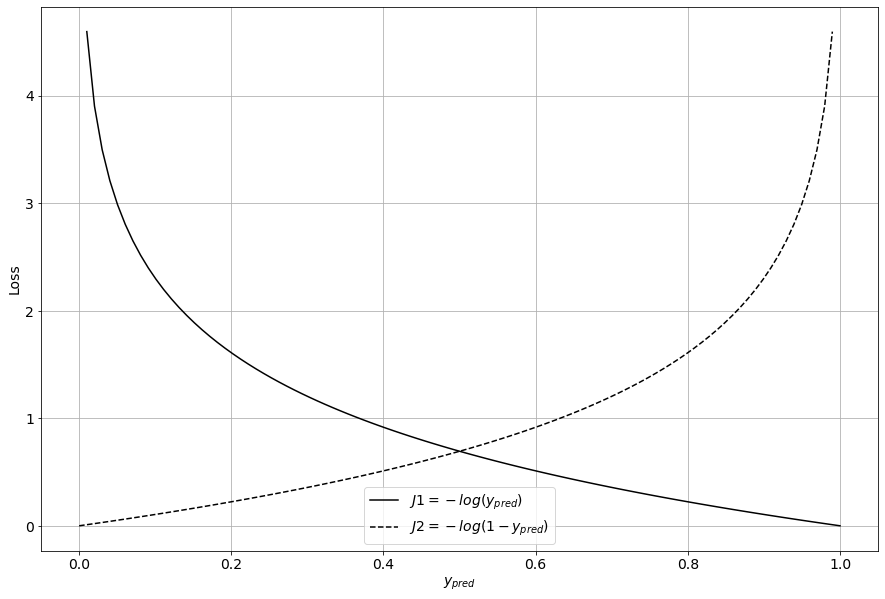

In [36]:
Y = np.linspace(0, 1, 100)
J_1 = -np.log(Y)
J_2 = -np.log(1-Y)

plt.plot(Y, J_1, 'k', Y, J_2, 'k--')
plt.grid()
plt.xlabel('$y_{pred}$')
plt.ylabel('Loss')
plt.legend(['$J1=-log(y_{pred})$', '$J2=-log(1-y_{pred})$'])

Суть используемых функций в том, что при сильном отклонении от целевой переменной ошибка будет расти нелинейно, что и способствует созданию более гладкой поверхности ошибки. Теперь главным вопросом является "Как объединить эти две функции в одну?". Для этого вспомним, что в задаче классификации истинные (True) значения принимают лишь значения 1 или 0.

Таким образом, делается простой трюк по объединению этих двух функций в одну: $$J=y*J_1+(1-y)*J_2$$ или $$J=-y*log(y_{pred})-(1-y)*log(1-y_{pred})$$

> Название этой функции бинарная кросс-энтропия (Binary Cross-Entropy ~ BCE).

> Такое представление вычисляет $J$ для одной записи в данных, для полного объема требуется найти среднее всех полученных значений $J$.

Смысл объединения в следующем: если истинное значение равно единице, то работает лишь первая часть функции, вторая обнуляется за счет $(1-y)$. Аналогично, когда истинное равно нулю. Так мы пытаемся сделать в векторе предсказания значение ближе к единице, если соответсвующий элемент в векторе истины равен единице. Аналогично свести значение элемента вектора предсказания к нулю, если соответсвующий ему элемент в векторе истины - ноль.

Вот таким нехитрым способом сформирована функция потерь для случаев, когда для предсказания используется функция сигмоиды.



# Производная функции потерь

Вспоминаем, что градиентный спуск работает по правилу 

$$
w_j \leftarrow w_j - \alpha \frac{\partial}{\partial w_j} J(W)
$$

поэтому для обучения нам требуется производная функции потерь по весам модели.

Полный вид функции потерь бинарной кросс-энтропии можно представить следующим образом:
$$
z = XW \\
h_W(z) = \sigma(z) = \frac{1}{1+e^{-z}} \\
J=-y*log(h_W(X))-(1-y)*log(1-h_W(X))
$$

Теперь мы можем воспользоваться правилом цепочки и развернуть градиент:
$$
\frac{\partial J}{\partial w_j} = 
\frac{\partial J}{\partial h_W}
\frac{\partial h_W}{\partial z}
\frac{\partial z}{\partial w_j} 
$$

Таким образом мы разделили задачу на три части:

- Производная линейной регрессии
$$
\frac{\partial z}{\partial w_j} = \frac{\partial}{\partial w_j} XW = X
$$

> Основная идея заключается в том, что производная линейного уравнения $w_0*1 + w_1*x_1 + \dots$ в зависимости от веса, по которому берется производная, дает значение признака по индексу $j$, что есть колонка данных.

- Производная сигмоиды по аргументу

> Это очень простой случай и его проще запомнить, чем вывести, но при желании обратитесь сюда: https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e

$$
\frac{\partial h_W}{\partial z} = 
\frac{\partial \sigma(z)}{\partial z} = 
\sigma(z)(1-\sigma(z)) = 
h_W(1-h_W)
$$

- Производная функции потерь по функции предcказания

$$
\frac{\partial J}{\partial h_W} = 
-[\frac{\partial}{\partial h_W}y*log(h_W) + \frac{\partial}{\partial h_W} (1-y)*log(1-h_W)]
$$

> Ну вы помните, производная суммы -> сумма производных

$$
\frac{\partial}{\partial h_W}y*log(h_W) = \frac{y}{h_W}
$$

$$
\frac{\partial}{\partial h_W}(1-y)*log(1-h_W) = \frac{(1-y)}{(1-h_W)} * \frac{\partial}{\partial h_W}(1-h_W) = -\frac{(1-y)}{(1-h_W)}
$$

> Здесь мы воспользовались правилом $\frac{\partial}{\partial x}f(g(x)) = \frac{\partial}{\partial g}f(g(x)) * \frac{\partial}{\partial x}g(x)$

$$
\frac{\partial J}{\partial h_W} = -[\frac{y}{h_W} - \frac{(1-y)}{(1-h_W)}] = \\
-[\frac{y(1-h_W) - h_W(1-y)}{h_W(1-h_W)}] = 
\frac{h_W-y}{h_W(1-h_W)}
$$

- Объединяем все вместе:

$$
\frac{\partial J}{\partial w_j} = X^T * h_W(1-h_W) * \frac{h_W-y}{h_W(1-h_W)} = 
X^T(h_W-y)
$$

> Транспонирование $X$ связано с тем, что матрица имеет формат, по которому каждый столбец = признак, а формат градиента - ряд = признак. Если проверить формат, то мы умножаем матрицы $[m, n]*[n, 1]$ и получаем вектор $[m, 1]$ производных.

Таким образом получена формула для вычисления производной функции потерь $BCE$, самое время реализовать как саму фукнцию потерь, так и ее производную:

> Не забудьте, что результатом `bce_loss()` функции должен получиться скаляр, в результатом `bce_loss_deriv()` - вектор с размерностью по количеству признаков в матрице $X$.

In [37]:
def bce_loss(y_true, y_pred):
    # TODO - функция потерь
    n = y_true.shape[0]
    loss = np.sum(-y_true * np.log(y_pred) - (1-y_true) * np.log(1-y_pred))/n
    return loss

def bce_loss_deriv(X, y_true, y_pred):
    # TODO - производная функции потерь
    n = y_true.shape[0]
    dJ = X.T.dot(y_pred-y_true) / n
    return dJ

In [38]:
# Проверка
y_true = np.array([0, 0, 1, 1])
y_pred = np.array([0.98, 0.3333, 0.2, 0.8])

X = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [8, 9, 0],
    [7, 6, 5],
])

loss = bce_loss(y_true, y_pred)
dJ = bce_loss_deriv(X, y_true, y_pred)

dJ_true = np.array([-1.53835, -1.360025, 0.8183]) 

assert loss == 1.5375048946336445
assert np.all(np.abs(dJ-dJ_true) < 1e-8)

# Обучение модели

## Задание

Настало время обучить нашу модель и эта задача переходит вам! Давайте напишем функцию обучения модели. Учтите следующие особенности:
- в ходе обучения применяется степень уверенности, а не конечный предсказанный класс;
- функция `predict_proba()` принимает на вход исходные данные и сама добавляет колонку, функция `bce_loss_deriv()` более общая и не добавляет колонку единиц.

In [39]:
# def bce_loss_deriv_2(X, W, y):
#     # TODO - производная функции потерь
#     y_pred = predict_proba(X, W)
#     ones = np.ones((X.shape[0], 1), dtype=int)
#     X = np.concatenate((ones, X), axis=1)
#     n = y.shape[0]
#     dJ = (X.T @ (y_pred-y)) / n
#     return dJ
def fit_model(X, y, lr, n_iter):
    # TODO - функция обучения модели
    W = np.zeros(X.shape[1]+1)
    loss_history = []
    ones = np.ones((X.shape[0], 1), dtype=int)
    X1 = np.concatenate((ones, X), axis=1)
    y_pred = predict_proba(X, W)
    print(f'Data shape: {X.shape}')
    print(f'Start weights: {W}')
    for i_iter in range(n_iter):
        # TODO - добавьте код обновления и вычисления предсказаний
        dJ = bce_loss_deriv(X1, y, y_pred)
        W -= lr*dJ
        y_pred = predict_proba(X, W)
        loss = bce_loss(y, y_pred)
        loss_history.append(loss)
    
    print(f'Result weights: {W}')
    return W, loss_history


def show_loss(loss_history):
    # TODO - функция отображения истории обучения
    plt.plot(loss_history)
    plt.grid()
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('$J(X)$')
    plt.show()

Data shape: (70, 2)
Start weights: [0. 0. 0.]
Result weights: [-9.35950541  2.19908447  0.299076  ]


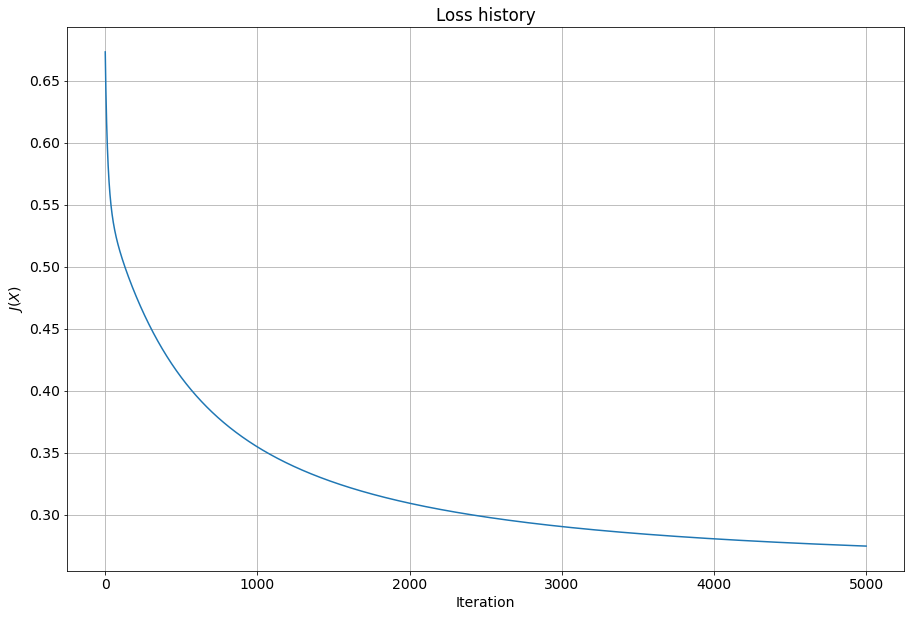

In [40]:
trained_W, loss_history = fit_model(
    lr=0.1,
    n_iter=5000,
    X=X_train,
    y=y_train
)

show_loss(loss_history)

Отлично, если значение функции потерь постепенно снижается в истории, значит все сделано верно, давайте теперь посмотрим, как работает обученная модель.

Отобразите метрики, матрицу ошибок и визуализируйте пространство принятия решений:

In [41]:
# TODO - Отобразите значения метрик
y_pred = predict(X_train, trained_W, 0.5)
show_classification_metrics(y_train, y_pred)

Class 1 metrics: (0.9428571428571428, 0.9428571428571428, 0.9428571428571428)
Class 0 metrics: (0.9428571428571428, 0.9428571428571428, 0.9428571428571428)
Accuracy: 0.9428571428571428


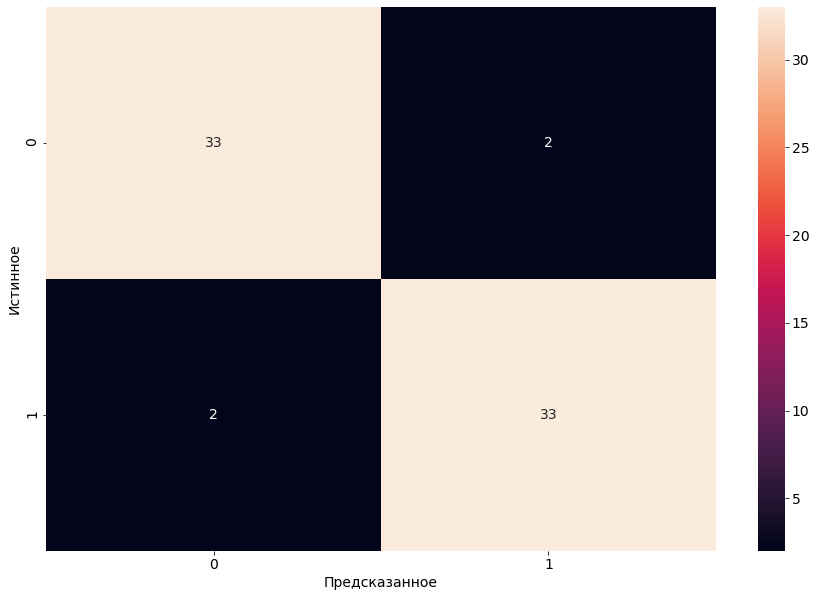

In [42]:
# TODO - Отобразите матрицу ошибок
conf_matrix = get_confusion_matrix(y_train, y_pred)
show_confusion_matrix(conf_matrix)

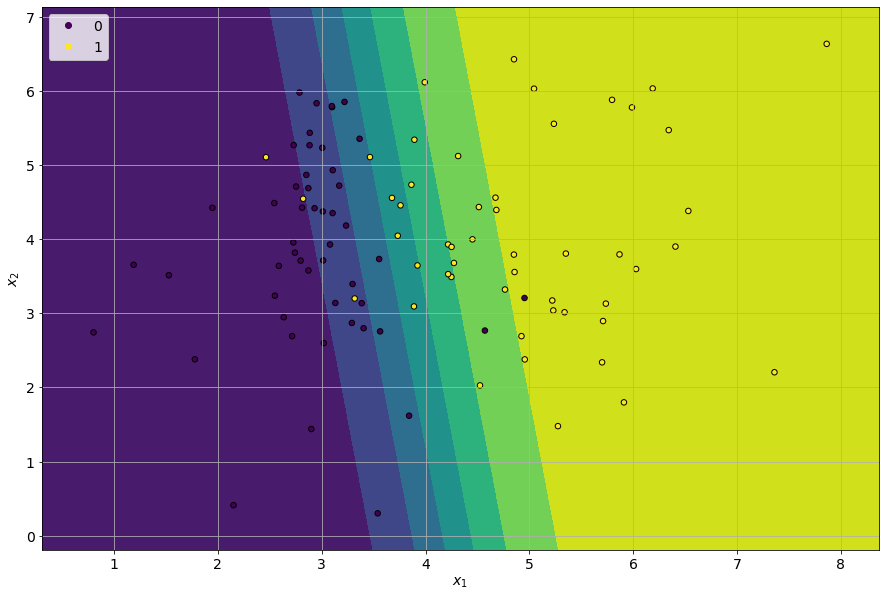

In [43]:
plot_2d_decision_boundary(X_data, trained_W, y_data)

Отлично! Наша модель обучена и предсказывает явно лучше, чем модель со случайно выбранными весами!

## Задание

Изучите, как меняются показатели в зависимости от выбранного порога (7 разных значений в диапазоне $[0.1; 0.95]$.

In [44]:
# TODO
# arr_thrs = np.linspace(0.1, 0.95, 7)
# y_true = y_test
# for thrs in arr_thrs:
#     print(f'threshold = {thrs:.2f}')
#     y_pred = predict(X_test, trained_W, thrs)
#     show_classification_metrics(y_true, y_pred)
#     print('--------------------------------')
for i in np.linspace(0.1, 0.95, 7):
    y_pred = predict(X_train, trained_W, i)
    show_classification_metrics(y_train, y_pred)
    print(f'Порог = {i}')
    print('--------------------------------')

Class 1 metrics: (0.9714285714285714, 0.5862068965517241, 0.7311827956989247)
Class 0 metrics: (0.3142857142857143, 0.9166666666666666, 0.4680851063829787)
Accuracy: 0.6428571428571429
Порог = 0.1
--------------------------------
Class 1 metrics: (0.9714285714285714, 0.7727272727272727, 0.8607594936708862)
Class 0 metrics: (0.7142857142857143, 0.9615384615384616, 0.819672131147541)
Accuracy: 0.8428571428571429
Порог = 0.24166666666666667
--------------------------------
Class 1 metrics: (0.9428571428571428, 0.9166666666666666, 0.9295774647887323)
Class 0 metrics: (0.9142857142857143, 0.9411764705882353, 0.9275362318840579)
Accuracy: 0.9285714285714286
Порог = 0.3833333333333333
--------------------------------
Class 1 metrics: (0.8857142857142857, 0.9393939393939394, 0.9117647058823529)
Class 0 metrics: (0.9428571428571428, 0.8918918918918919, 0.9166666666666667)
Accuracy: 0.9142857142857143
Порог = 0.525
--------------------------------
Class 1 metrics: (0.8, 0.9333333333333333, 0.861

## ROC кривая и AUC

> **ROC** - receiver operating characteristic, если вам это о чем-то скажет =)

> **AUC** - area under curve, площадь под кривой.

В работе с классификацией возникает большой вопрос, неужели нам нужно все время проверять каждое возможное значение порога при сравнении моделек? Как нам выбирать лучшую, ведь от значения порога зависят значения тех или иных показателей!

Вот здесь мы и взглянем на ROC-кривую и оценим AUC этой кривой. Такой показатель принято называть *ROC-AUC*.

Для построения ROC-кривой на понадобятся две характеристики:
- **True Positive Rate** (TPR)
$$
TPR = \frac{TP}{TP+FN}
$$

Не замечаете сходство? Именно! Это показатель Recall! Он показывает, насколько хорошо модель предсказывает записи положительного класса.

- **False Positive Rate** (FPR)
$$
FPR = \frac{FP}{FP+TN}
$$

Такой показатель мы еще не встречали, как видно по формуле, показатель отражает, насколько правильно модель предсказывает записи негативного класса.

Давайте представим два случая:
- Случай 1. Алгоритм предсказал все записи как записи положительного класса! В таком случае мы имеем TPR = 1.0, так как все записи с положительным классом предсказаны верно и FPR = 0, так как абсолютно все записи негативного класса предсказаны неверно!
- Случай 2. Обратный, когда все предсказаны как негативный класс. Тогда TPR = 0, а FPR = 1. Думаю, тут понятно, почему.

Такие случай могут появиться, когда мы выбираем в качестве порога значение близкое к нулю (тогда любому примеру присваивается положительный класс, так как трудно не попасть в условие "выше порога") или близкое к единице (тогда все классы попадают в негативный класс). Это крайние случаи. Все промежуточные показатели этих характеристик отражают способность модели классифицировать данные. На этом остановим разбор и напишем код реализации получения требуемых показателей и рисования ROC-кривой. После станет все намного понятнее!

In [45]:
# TODO - напишите функции получения TRP и FPR

def get_tpr_fpr_metrics(y_true, y_pred, class_index):
    TP, TN, FP, FN = get_truefalse_metrics(y_true, y_pred)
    if class_index == 1:
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
    elif class_index == 0:
        TPR = TN / (TN + FP)
        FPR = FN / (FN + TP)
    return TPR, FPR

In [46]:
# TEST
y_true = np.array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0])
y_pred = np.array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

tpr_0, fpr_0 = get_tpr_fpr_metrics(y_true, y_pred, 0)

assert np.isclose(tpr_0, 0.5)
assert np.isclose(fpr_0, 0.5)

Теперь самое время пробежаться по 11 значениям порога (с шагом 0.1) и отобразить кривую, которая получается в осях значений (x ~ FPR и y ~ TPR).

In [47]:
def show_roc_curve(X, y, W, class_index):
    diag_values = np.array([
        [0, 0],
        [1, 1],
    ])

    render_n_points = 10
    threshold_values = np.arange(render_n_points+1)/render_n_points
    tpr_values = []
    fpr_values = []

    for threshold_value in threshold_values:
        y_pred = predict(X, W, threshold=threshold_value)
        tpr_0, fpr_0 = get_tpr_fpr_metrics(y, y_pred, class_index)

        tpr_values.append(tpr_0)
        fpr_values.append(fpr_0)

    plt.plot(fpr_values, tpr_values)
    plt.plot(diag_values[:,0], diag_values[:,1], 'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

Теперь для примера отобразим характеристики модели с обученными весами и модели со случайными весами.

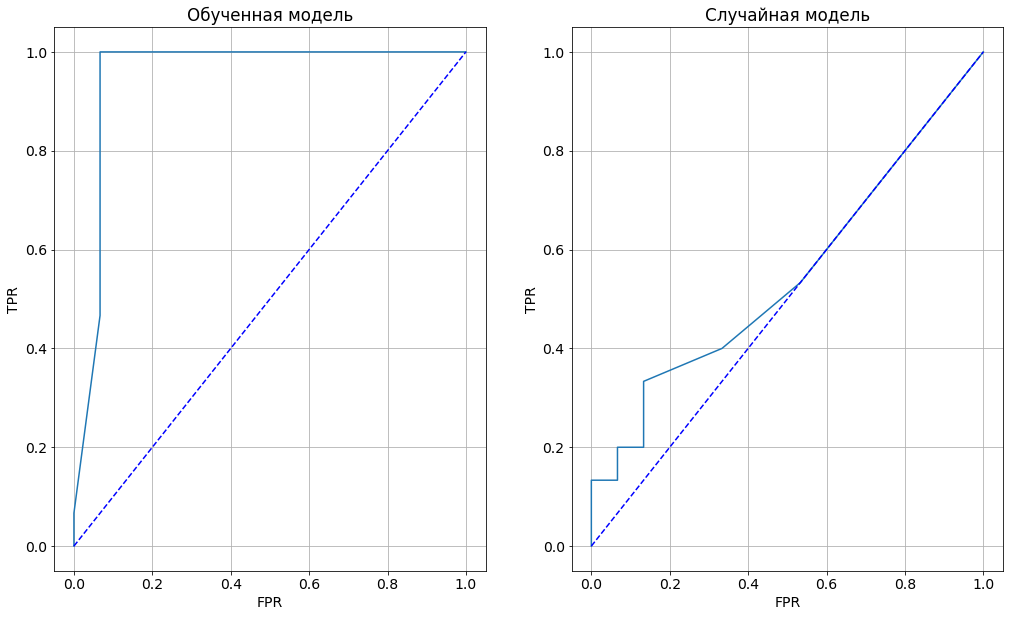

In [48]:
y_true = y_test
plt.figure(figsize=[17,10])
plt.subplot(121)
show_roc_curve(X_test, y_true, trained_W, class_index=0)
plt.title('Обученная модель')
plt.subplot(122)
show_roc_curve(X_test, y_true, rand_W, class_index=0)
plt.title('Случайная модель')
plt.show()

Можно увидеть, что модель с обученными весами имеет большую площадь под кривой (сплошная линия), чем модель со случайными весами. Это и есть AUC! То есть по данному показателю та модель лучше, у которой AUC этой кривой выше.

> Можно еще сформулировать так, что модель лучше, если кривая ближе к верхнему левому углу.

Диагональная линия проведена для отсчета, так как модель, у которой ROC является этой диагональной линией - это модель, которая случайно предсказывает класс. Таким образом, модели с кривой выше диагонали - уже лучше, чем случайность, ниже - все еще хуже. Такой показатель позволяет сравнивать работу различных моделей для полной оценке, нежели сравнения работы моделей с конкретным порогом.

## Задание - PR-кривая

Теперь, когда вы освоили отображение ROC-кривой, реализуйте и сравните модели по другому показателю под названием PR-кривая. Суть и идея все те же, смотрим на значения Precision и Recall на разных порогах и рисуем кривую в осях (x ~ Recall, y ~ Precision).

In [49]:
# TODO - реализуйте и отобразите PR-кривые двух моделей
def show_pr_curve(X, y, W, class_index):
    diag_values = np.array([
        [0, 0],
        [1, 1],
    ])

    threshold_values = np.linspace(0.1, 0.95, 10)
    recall_values = []
    precision_values = []

    for threshold_value in threshold_values:
        y_pred = predict(X, W, threshold=threshold_value)
        recall, precision, f1 = calculate_recall_precision_f1(y, y_pred, class_index)
        recall_values.append(recall)
        precision_values.append(precision)

    plt.plot(recall_values, precision_values)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)

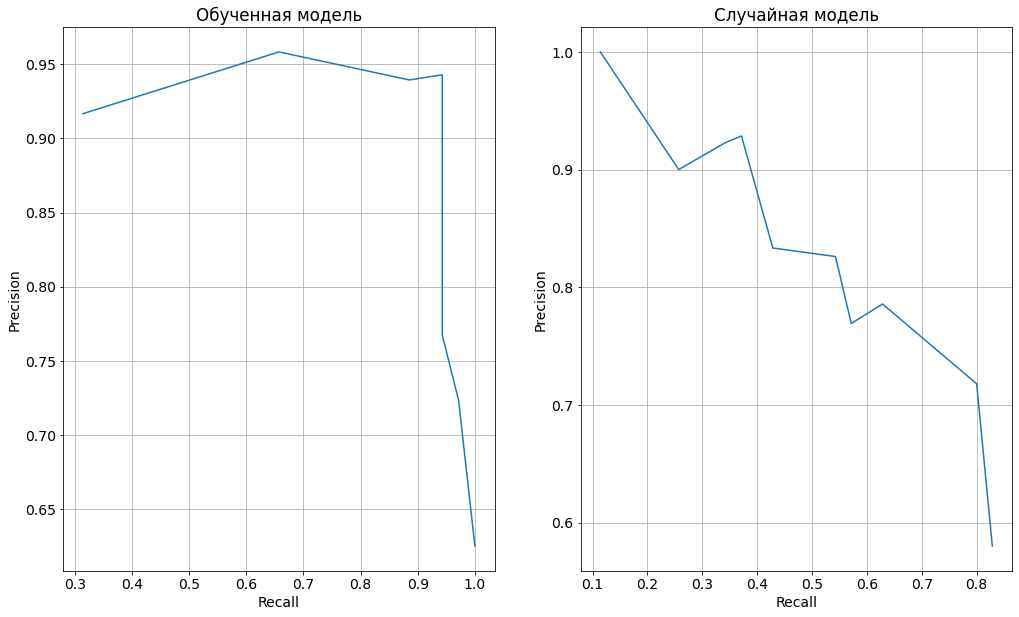

In [50]:
plt.figure(figsize=[17,10])
plt.subplot(121)
show_pr_curve(X_train, y_train, trained_W, class_index=0)
plt.title('Обученная модель')
plt.subplot(122)
show_pr_curve(X_train, y_train, rand_W, class_index=0)
plt.title('Случайная модель')
plt.show()

# Кросс-валидация

Метод разделения на обучение/тест является достаточно важным для применения, так как он позволяет оценить работу модели по данным, которые не были использованы в обучении. Тем не менее при малом объеме данных случайная тестовая выборка может быть слишком смещена и оценка будет искажена. Поэтому для того, чтобы произвести усредненную оценку на всем объеме данных, существует метод, названный К-фолд кросс-валидация.

![Взято с https://scikit-learn.org/stable/modules/cross_validation.html](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Суть метода заключается в том, что обучающая выборка разделяется на $K$ наборов (фолды) данных, далее в цикле $K$ раз происходит обучение на $K-1$ наборах, а на оставшемся производится оценка - таким образом происходит обучение и оценка $K$ раз. В результате выполнения кросс-валидации получаются $K$ оценок, по которым можно более трезво судить о работе модели путем усреднения, так как производится оценка на всех возможных выборках.

> Как показано на картинке, тестовые данные должны быть отобраны всегда для проведения конечной оценки. При реализации метода K-fold мы опустим финальную оценку и воспользуемся методом на всем наборе данных.

Последовательность метода следующая:
- Случайно перемешать набор данных;
- Разделить данные на K выборок;
- Произвести K итераций:
  - Взять K-ю выборку как тестовую;
  - Остальные выборки взять как обучающие данные;
  - Обучить модель;
  - Произвести оценку на тестовой выборке;
- Усреднить оценки на всех итерациях;

В качестве оцениваемой метрики воспользуемся средней F1 мерой по всем классам. Для R выберем значение 5. 

Реализуйте K-fold обучение и оценку по методу кросс-валидации:

In [63]:
# TODO - напишите реализацию K-fold разделения
def get_kfold_splits(n_samples, kfolds):
    ''' Функция получения индексов для разделения на K фолдов
    
    Параметры
    ---------
    n_samples: int
        Количество записей в данных
    k: int
        Количество фолдов
    
    Возвращает
    ----------
    Список, в котором находится k пар (кортежей)
        Каждая пара представляет собой два массива:
        - массив индексов обучающей выборки
        - массив индексов тестовой выборки
    '''
    folds_indexes = []
    # Создайте список перемешанных индексов записей
    index_rand = np.random.permutation(range(n_samples))

    # Получите размер фолда
    folds = (int) (n_samples/kfolds)
    for i in range(kfolds):
    # Создайте массив нулей с типом bool
    # Это будет маска для выбора индексов обучения/теста
        mask = np.zeros(n_samples, dtype=bool)

    
        start_idx = int(i*folds)
        end_idx = start_idx + folds
        
        mask[start_idx: end_idx] = True
        # По маске из перемешанных индексов получите индексы тестового фолда
        #   test_indexes
        test_indexes = np.where(mask == True)
        
        # По инвертированной маске из перемешанных индексов 
        #   получите индексы обучающего фолда
        #   train_indexes
        train_indexes = np.where(mask != True)
        # Запишем пару массивов индексов в результирующий список
        folds_indexes.append(
            (train_indexes, test_indexes)
        )

    return folds_indexes

In [64]:
# TODO - напишите процесс обучения и оценки с K-fold CV

K_FOLDS = 5
f1_scores = []

for train_indexes, test_indexes in get_kfold_splits(X_data.shape[0], K_FOLDS):
    # По индексам фолдов получите 
    #   {X,y}_{train,test} из данных X_data
    X_train = X_data[train_indexes]
    y_train = y_data[train_indexes]
    
    X_test = X_data[test_indexes]
    y_test = y_data[test_indexes]
    # Произведите обучение модели, оцените на тестовом фолде
    #   и получите среднее значение f1 по всем классам, 
    #   добавьте значение в массив f1_scores
    trained_W, loss_history = fit_model(
            lr=0.1,
            n_iter=5000,
            X=X_data[train_indexes],
            y=y_data[train_indexes]
            )
    y_pred = predict(X_test, trained_W, 0.5)
    recall_1, precision_1, f1_1 = calculate_recall_precision_f1(y_test, y_pred, 1)
    recall_0, precision_0, f1_0 = calculate_recall_precision_f1(y_test, y_pred, 0)
    f1_scores.append(np.mean(f1_0 + f1_1))

# Получите среднее значение по массиву f1_scores
print('-----------------------')
np.mean(f1_scores)

Data shape: (80, 2)
Start weights: [0. 0. 0.]
Result weights: [-9.57000899  2.33972295  0.22226613]
Data shape: (80, 2)
Start weights: [0. 0. 0.]
Result weights: [-9.74499209  2.41114356  0.19337784]
Data shape: (80, 2)
Start weights: [0. 0. 0.]
Result weights: [-9.32655492  2.29633323  0.22635756]
Data shape: (80, 2)
Start weights: [0. 0. 0.]
Result weights: [-9.87288096  2.32669225  0.2993344 ]
Data shape: (80, 2)
Start weights: [0. 0. 0.]
Result weights: [-9.09078881  2.1157648   0.30238976]
-----------------------


1.8691285715326635

# Дисбаланс классов в данных

В нашем рассмотренном случае мы работали с данными, в которых количество записей для одного и другого классов были приблизительно одинаковым:

In [65]:
y_data[y_data == 0].shape, y_data[y_data == 1].shape 

((50,), (50,))

Если мы обратимся к реальным задачам, то некоторые из них выделяются, так, например, задача определения мошенничества с банковскими картами часто выделяется, так как на сегодняшний день карты очень распространены и на несколько миллионов транзакций приходится в более чем 100 раз меньше мошеничеств с картами. Как это отразится в данных? Мы будем иметь огромное количество записей с классом "не мошеничество", и всего несколько "мошеничество". Для примера создадим вектора истинных значений и предсказанных моделью, которая всегда предсказывает "не мошеничество":

In [66]:
y_true = np.zeros(100, dtype=int)
y_true[:3] = 1

y_pred = np.zeros(100, dtype=int)

y_true, y_pred

(array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

Видите, в истинных значениях всего 3 случая мошеничества, а модель просто всегда говорит, что мошеничества нет, так давайте оценим метрики:

In [67]:
try:
    show_classification_metrics(y_true, y_pred)
except ZeroDivisionError:
    print('ZeroDivisionError')

Class 1 metrics: (0.0, nan, nan)
Class 0 metrics: (1.0, 0.97, 0.9847715736040609)
Accuracy: 0.97


<ipython-input-27-d8659b93e7a9>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP+FP)


> Наш ручной расчет показателей не учитывает деление на 0 ($TP+FP = 0$), так что значения стали `nan`, но по факту это нулевое значение, так как полностью отсутствуют значения $TP$ для класса "мошенничество".

Обратите внимание, что как точность, так и показатели для класса "не мошеничество" практически равны единице, при этом показатели для первого класса близки к нулю. Если бы мы смотрели только на accuracy, то нам не пришлось бы разрабатывать модель - всегда предсказывать "не мошенничество" дает прекрасные показатели. Вот только вряд ли пользователи системы обрадовались бы, когда определили, что система никогда не предсказывает мошенничество =(

Именно для таких случаев анализируются как показатели по каждому классу, так и матрица ошибок, так как по ней сразу видно, что класс "мошенничество" не предсказывается вовсе.

Для практики работы с данными, которые имеют дисбаланс создадим искуственный датасет:

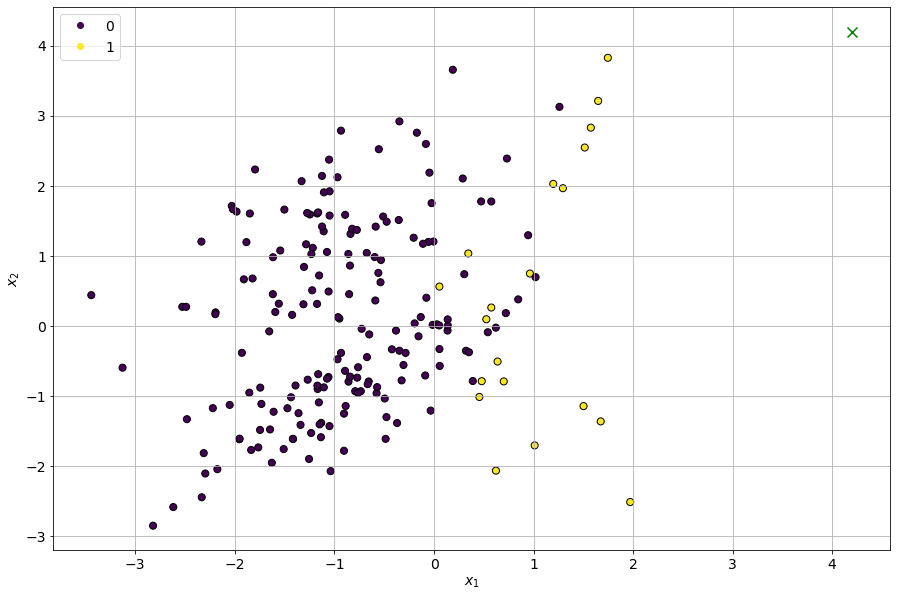

In [68]:
X_data, y_data = make_classification(
    n_samples=200,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=2,
    random_state=RANDOM_STATE,
    weights=[0.9, 0.1]
)

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k', )
plt.scatter(X_new[:, 0], X_new[:, 1], marker='x', s=100, edgecolor='k', c='green')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])

In [69]:
y_data[y_data == 0].shape, y_data[y_data == 1].shape 

((180,), (20,))

Как видим, записей класса 0 в разы больше, чем данных класса 1 - это и есть представление дисбаланса.

## Задание

Поразмышляйте, какие негативные стороны имеет метод разделения на обучение/тест случайной выборкой при наличии дисбаланса классов.

Теперь, давайте обучим нашу модель и оценим, как она работает при наличии такого дисбаланса данных. Оценку проведем методом кросс-валидации для всех данных для усреднения оценки.

> Дополнительно выведите стандартное отклонение значений оценок (`f1_scores`), чтобы понять, как это скажется на данных.

Для этого необходимо в первую очередь реализовать функцию генерации K-фолдов с учетом стратификации:

In [90]:
# TODO - разберите вместе с преподавателем
def get_kfold_splits_stratified(y, kfolds):
    ''' Функция получения индексов для разделения на K фолдов
            со стратификацией по y
    
    Параметры
    ---------
    y: [n_samples]
        Вектор целевых классов, по которому будет производиться стратификация
    k: int
        Количество фолдов
    
    Возвращает
    ----------
    Список, в котором находится k пар (кортежей)
        Каждая пара представляет собой два массива:
        - массив индексов обучающей выборки
        - массив индексов тестовой выборки
    '''
    folds_indexes = []
    n_samples = len(y)
    step = n_samples/kfolds

    classes_indices = {}
    unique_classes = np.unique(y)
    for k in unique_classes:
        class_indices = np.where(y==k)[0]
        class_indices = np.random.permutation(class_indices)
        classes_indices[k] = class_indices

    for i in range(kfolds):
        test_indexes = []
        train_indexes = []

        for k in unique_classes:
            class_indices = classes_indices[k]
            step = len(class_indices)/kfolds

            start_idx = int(i*step)
            end_idx = int((i+1)*step)          

            mask = np.zeros_like(class_indices, dtype=bool)
            mask[start_idx:end_idx] = True

            test_indexes.extend(class_indices[mask])
            train_indexes.extend(class_indices[~mask])
        
        train_indexes = np.random.permutation(train_indexes)
        test_indexes = np.random.permutation(test_indexes)

        folds_indexes.append(
            (train_indexes, test_indexes)
        )

    return folds_indexes

In [91]:
# Проверка
folds = get_kfold_splits_stratified(y_data, K_FOLDS)

fold = folds[2]
test_indexes = fold[1]

assert  (y_data[test_indexes] == 1).sum() == 4

In [92]:
# TODO - напишите реализацию обучения со стратификацией CV
for train_indexes, test_indexes in get_kfold_splits_stratified(y_data, K_FOLDS):
    # По индексам фолдов получите 
    #   {X,y}_{train,test} из данных X_data
    X_train = X_data[train_indexes]
    y_train = y_data[train_indexes]
    
    X_test = X_data[test_indexes]
    y_test = y_data[test_indexes]
    trained_W, loss_history = fit_model(
            lr=0.1,
            n_iter=5000,
            X=X_data[train_indexes],
            y=y_data[train_indexes]
            )
    thrs = 0.5
    y_pred = predict(X_test, trained_W, 0.5)
    recall_1, precision_1, f1_1 = calculate_recall_precision_f1(y_test, y_pred, 1)
    recall_0, precision_0, f1_0 = calculate_recall_precision_f1(y_test, y_pred, 0)
    f1_scores.append(np.mean(f1_0 + f1_1))

# Получите среднее значение по массиву f1_scores
print('-----------------------')
np.mean(f1_scores)

Data shape: (160, 2)
Start weights: [0. 0. 0.]
Result weights: [-3.35281794  4.94579476 -0.93685125]
Data shape: (160, 2)
Start weights: [0. 0. 0.]
Result weights: [-2.76506627  4.46468911 -0.86127704]
Data shape: (160, 2)
Start weights: [0. 0. 0.]
Result weights: [-2.81987728  4.35459445 -0.85708647]
Data shape: (160, 2)
Start weights: [0. 0. 0.]
Result weights: [-2.71662497  4.43441733 -0.90326664]
Data shape: (160, 2)
Start weights: [0. 0. 0.]
Result weights: [-2.94405035  4.50022232 -0.79944026]
-----------------------


nan

В практике мы познакомимся с тремя методами работы с данными. Первым будет метод под названием **Соберите больше данных**. Без шуток, иногда это является наиболее простым и, главное, действенным методом. Действенность заключается в том, что остальные два (и многие другие) метода синтетически изменяют данные, что в результате не привносит новой полезной информации в данные, так что новые данные могут не только выровнять дисбаланс, но и улучшить работу модели за счет привнесения и уточнения зависимостей в данных.

С первым методом понятно, а теперь перейдем к методу синтетического расширения - **Oversample**. Суть метода в том, что мы искуственно увеличиваем количество записей того класса, о котором мало информации. Существуют разные способы такого расширения, но мы попробуем самый простой - банальное повторение записей.

В следующем блоке реализуйте повторение записей для класса 1 так, чтобы количество записей для класса 1 стало равно количеству записей класса 0. В этом вам поможет функция `numpy.random.choice()`, которой можно передать массив, и она случайно выберет такое количество элементов, которое было передано аргументом `size`.

> Для реализации рекомендуется разделить данные на отдельные массивы, сделать обработку данных через oversample, а затем объединить расширенные данные класса 1 и исходные класса 0. 

In [107]:
# TODO - напишите реализацию метода oversample
def oversample_by_class(X, y, oversample_class, target_count):
#     ind_class = np.where(y == oversample_class)[0]
#     over_ind_class = np.random.choice(ind_class, size=target_count)
#     X_append = X[over_ind_class]
#     y_append = y[over_ind_class]
#     return X_append, y_append
    Xy = np.concatenate((X, y.reshape((X.shape[0], 1))), axis=1)
    ind_class = np.where(y == oversample_class)[0]
    over_ind_class = np.random.choice(ind_class, size=target_count)
    Xy_class = Xy[over_ind_class]
    Xy_notclass = Xy[~(y == oversample_class)]
    Xy = np.concatenate((Xy_class, Xy_notclass), axis=0)
    Xy = np.random.permutation(Xy)
    X = Xy[:, :2]
    y = Xy[:, 2]
    return X, y

In [108]:
# Проверка
X_check, y_check = oversample_by_class(X_data, y_data, 1, 200)

assert (y_check==1).sum() == 200

In [113]:
class0_count = (y_data==0).sum()
X_new_data, y_new_data = oversample_by_class(X_data, y_data, 1, class0_count)

K_FOLDS = 5
f1_scores = []
# TODO - напишите процесс обучения
for train_indexes, test_indexes in get_kfold_splits_stratified(y_new_data, K_FOLDS):
    # По индексам фолдов получите 
    #   {X,y}_{train,test} из данных X_data
    X_train = X_new_data[train_indexes]
    y_train = y_new_data[train_indexes]
    
    X_test = X_new_data[test_indexes]
    y_test = y_new_data[test_indexes]
    trained_W, loss_history = fit_model(
            lr=0.1,
            n_iter=5000,
            X=X_new_data[train_indexes],
            y=y_new_data[train_indexes]
            )
    y_pred = predict(X_new_data[test_indexes], trained_W, 0.5)
    recall_1, precision_1, f1_1 = calculate_recall_precision_f1(y_test, y_pred, 1)
    recall_0, precision_0, f1_0 = calculate_recall_precision_f1(y_test, y_pred, 0)
    f1 = (f1_0 + f1_1)/2
    f1_scores.append(f1)

# Получите среднее значение по массиву f1_scores
print('-----------------------')
np.mean(f1_scores)

Data shape: (288, 2)
Start weights: [0. 0. 0.]
Result weights: [-0.89361707  4.6195301  -0.73423628]
Data shape: (288, 2)
Start weights: [0. 0. 0.]
Result weights: [-0.68052951  4.28961206 -0.55870316]
Data shape: (288, 2)
Start weights: [0. 0. 0.]
Result weights: [-0.61900765  4.8076737  -0.70221285]
Data shape: (288, 2)
Start weights: [0. 0. 0.]
Result weights: [-0.89679398  4.78029673 -0.69583696]
Data shape: (288, 2)
Start weights: [0. 0. 0.]
Result weights: [-0.90629402  5.33705877 -0.34711739]
-----------------------


0.9248004186134864

Отлично, в результате увеличения количества данных для класса 1 не только подрос, но и уменьшился разброс в оценках фолдов.

Последним методом обработки дисбаланса классов в данных является **Undersample**. На самом деле, метод заключается в абсолютно обратном, вместо синтетического увеличения данных для класса с малым объемом записей, мы уменьшаем количество записей для класса, который превалирует, тем самым выравнивая баланс.

В следующей ячейке реализуйте уменьшение количества данных для класса 0 до размера выборки для класса 1. В этом вам все также поможет функция `numpy.random.choice()`.

In [114]:
# TODO - напишите реализацию метода undersample
def undersample_by_class(X, y, undersample_class, target_count):
#     ind_class = np.where(y == undersample_class)[0]
#     under_ind_class = np.random.choice(ind_class, size=target_count)
#     X_del = X[under_ind_class]
#     y_del = y[under_ind_class]
#     return X_del, y_del
    Xy = np.concatenate((X, y.reshape((X.shape[0], 1))), axis=1)
    ind_class = np.where(y == undersample_class)[0]
    over_ind_class = np.random.choice(ind_class, size=target_count)
    Xy_class = Xy[over_ind_class]
    Xy_notclass = Xy[~(y == undersample_class)]
    Xy = np.concatenate((Xy_class, Xy_notclass), axis=0)
    Xy = np.random.permutation(Xy)
    X = Xy[:, :2]
    y = Xy[:, 2]
    return X, y

In [115]:
# Проверка
X_check, y_check = undersample_by_class(X_data, y_data, 0, 200)

assert (y_check==0).sum() == 200

In [119]:
class1_count = (y_data==1).sum()
X_new_data, y_new_data = undersample_by_class(X_data, y_data, 0, class1_count)

K_FOLDS = 5
f1_scores = []

# TODO - напишите процесс обучения и оценки
for train_indexes, test_indexes in get_kfold_splits_stratified(y_new_data, K_FOLDS):
    # По индексам фолдов получите 
    #   {X,y}_{train,test} из данных X_data
    X_train = X_new_data[train_indexes]
    y_train = y_new_data[train_indexes]
    
    X_test = X_new_data[test_indexes]
    y_test = y_new_data[test_indexes]
    trained_W, loss_history = fit_model(
            lr=0.1,
            n_iter=5000,
            X=X_new_data[train_indexes],
            y=y_new_data[train_indexes]
            )
    y_pred = predict(X_new_data[test_indexes], trained_W, 0.5)
    recall_1, precision_1, f1_1 = calculate_recall_precision_f1(y_test, y_pred, 1)
    recall_0, precision_0, f1_0 = calculate_recall_precision_f1(y_test, y_pred, 0)
    f1 = (f1_0 + f1_1)/2
    f1_scores.append(f1)

# Получите среднее значение по массиву f1_scores
print('-----------------------')
np.mean(f1_scores)

Data shape: (32, 2)
Start weights: [0. 0. 0.]
Result weights: [-1.21088325  4.34327709 -0.30271046]
Data shape: (32, 2)
Start weights: [0. 0. 0.]
Result weights: [-2.01237853  5.83738658 -1.03398277]
Data shape: (32, 2)
Start weights: [0. 0. 0.]
Result weights: [-1.14627977  4.61610556 -0.97751738]
Data shape: (32, 2)
Start weights: [0. 0. 0.]
Result weights: [-1.17934739  6.93208359 -1.04575917]
Data shape: (32, 2)
Start weights: [0. 0. 0.]
Result weights: [-1.15835453  4.50237927 -0.69343272]
-----------------------


0.8984126984126984

Замечательно! Использование любого из этих методов позволяет получить стабилизацию показаний модели (стандартное отклонение стало меньше) и увеличение показателей качества!

Резюмируя, любой из трех рассмотренных методов позволит получить выравнивание данных, что приведет к более стабильному обучению и работе модели. При этом, если сбор новых данных является предпочтительным, то методы oversample и undersample имеют свои особенности:
- oversample синтетически балансирует данные, при это не привносит новой информации;
- undersample также позволяет достичь баланса классов, но при этом часть данных исключается.

# Мультиименная классификация

Рассмотренный случай бинарной классификации позволяет нам решать задачи, когда требуется данные разделить на всего две группы. Похожей задачей классификации является задача присваивания одного или нескольких классов по типу “навешивания ярлыков”. Такой тип задачи называется **мультиименная классификация**. 

В качестве примера можно привести случай, когда имеется набор видеофайлов и требуется определить жанры, к которым относятся видео. Допустим, что мы имеем четыре жанра: комедия, хоррор, боевик и мелодрама. Бинарная классификация тут в чистом виде не применима, так как количество классов больше двух, но мы можем позаимствовать идею бинарной классификации: а давайте сделаем четыре модели (по количеству классов) и каждая из них будет отвечать на вопрос, является ли видео этим жанром или нет!
Таким образом, первая модель будет выполнять задачу бинарной классификации по классам “комедия”/”не комедия”, вторая - “хоррор”/не хоррор” и т.д. По сути функция потерь, обучение и многие вещи заимствуются из бинарной классификации, но главным признаком мультиименной классификации является то, что выбранные **классы не исключают друг друга**. 



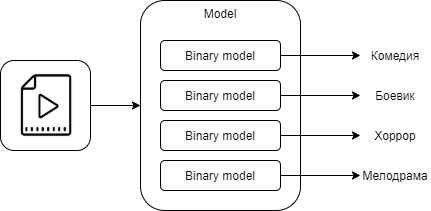

Для сравнения третий тип классификации, мультиклассовая (мультиноминальная) классификация, тоже работает с более чем двумя классами, но эти **классы исключают друг друга** - то есть можно выбрать исключительно один из возможных классов. Ее мы рассмотрим в следующей практике.

> Затрагивая тему типов классификации, важно отметить, что тип классификации выбирается исходя из тех задач, которые необходимо решить, и данных. Так, например, имея фоточки кошек, собак и опоссумов мы можем с одной стороны решать мультиноминальную классификацию, когда решаем, кто из трех находится на картинке (только один из трех, не все вместе), а с другой стороны, если на картинке может быть несколько животных, то можно и решить задачу мультименной классификации, когда подобно лейблам (тэгам) говорим, что тут есть собачка и кошечка или все трое и т.д.


# Выводы - Задание

Напишите выводы по итогам изучения материала (этот шаг поможет вам лучше запомнить информацию и создать какие-то свои ассоциации). В качестве "скелета" выводов можете использовать следующие вопросы, но лучше если вы проявите фантазию и изложите свои умозаключения!

1. Q: Чем отличается задача классификации от задачи регрессии? 
   A: В задаче классификации лежит предсказание из фиксированного набора значения, а в регрессии - предсказание вещественного числа
   
2. Q: Зачем нужны метрики? Что хорошего можно от них получить?
   A: Метрики служат для оценки обученной модели. С помощью них можно оценить достоверность модели и точность предсказания - этим они и польезны.
   
3. Q: Зачем разделять данные на тестовую выборку и выборку для обучения? Может "фигануть" всё одной кучей? 
   A: Чтобы не произошло переобучение. Да и вообще, точность повышается.
   
4. Q: А если в данных дисбаланс? Как учить то модель? 
   A: При дисбалансе, необходимо выровнять количество данных. С этим помогут undersample и oversample.

# Вопросики!

Подходи, налетай, на вопрос отвечай! 

1. Может ли количество классов быть неизвестным при задаче классификации? 
2. Зачем нужна сигмоида? Куда её применять? 
3. Слабо назвать 4 базовые метрики без запинки? 
4. Какую метрику нужно использовать, чтобы оценить общую работу классификатора? 
5. Какие метрики дают оценку какого-то конкретного класса? 
6. Что такое стратификация и причём тут сплит? 
7. Почему для задачи классификации есть своя собственная функция потерь? 
8. Как лучше разделить данные на тест и обучение, если самих данных мало?
9. Работает ли в машином обучении подход "у кого больше данных - тот король вечеринки"? 